# Домашнее задание

1. скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention
2. там поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.
3. сделать разбиение набора данных не тренировочную и тестовую выборки
4. сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)
5. провести uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями
6. в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% этих 3 моделей
7. построить модель UpliftTreeClassifier и попытаться описать словами полученное дерево
8. (опционально) для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift: 1) сделать прогноз и получить uplift для тестовой выборки 2) отсортировать тестовую выборку по uplift по убыванию 3) разбить на децили (pandas qcut вам в помощь) 4) для каждого дециля посчитать среднюю conversion
9. (опционально) построить модель UpliftRandomForestClassifier и попытаться описать словами полученное дерево

### 1. Загрузим библиотекки и наш датасет

In [1]:
# !pip install scikit-uplift==0.2.0
# !pip install catboost

In [2]:
import numpy as np
import pandas as pd

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklift.viz import plot_uplift_by_percentile
from sklift.models import TwoModels
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel
from catboost import CatBoostClassifier
from sklift.models import ClassTransformation

# df = pd.read_csv('train_case2.csv', ';')
df = pd.read_csv('data.csv')
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


### 2. Переименуем поля (conversion -> target, offer -> treatment) и приведем поле treatment к бинарному виду

In [3]:
df.rename(columns={"offer": "treatment", "conversion": "target"}, inplace=True)

In [4]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0


In [5]:
df['treatment'] = df['treatment'].apply(lambda x: 0 if x == 'No Offer' else 1)

In [6]:
df.head(3)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,1,0
1,6,329.08,1,1,Rural,1,Web,0,0
2,7,180.65,0,1,Surburban,1,Web,1,0


### 4. Переведем категориальные признаки в бинарные

In [7]:
# cat_cols = df.select_dtypes(include='object').columns.tolist()
# print(cat_cols)

In [8]:
# if set(cat_cols).issubset(df.columns):
#    df = pd.get_dummies(df, columns=cat_cols)
# df.head(3)

### Отделим данные от target и treatment

In [9]:
df_data = df.drop(['treatment', 'target'], 1)
df_treatment = df['treatment']
df_target = df['target']

### 3. Сделаем разбиение набора данных не тренировочную и тестовую выборки

In [10]:
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(df_data,
                                                                                     df_target,
                                                                                     df_treatment,
                                                                                     stratify=df[['treatment', 'target']],
                                                                                     test_size=0.3, 
                                                                                     random_state=42)

### 5. Проведем uplift-моделирование 3 способами: одна модель с признаком коммуникации (S learner), модель с трансформацией таргета (трансформация классов п. 2. 1) и вариант с двумя независимыми моделями

uplift@10%: 0.1013
uplift@20%: 0.0837


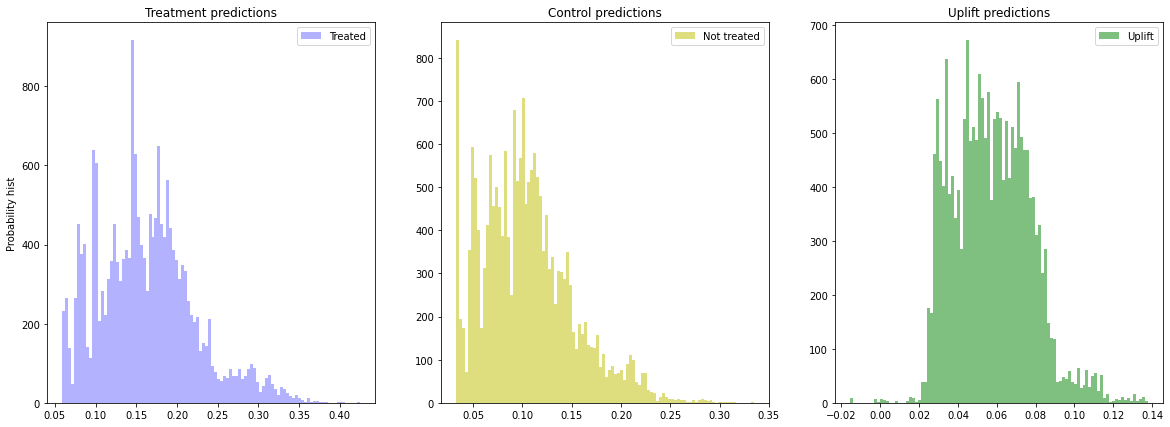

In [11]:
cat_cols = df.select_dtypes(include='object').columns.tolist()

sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_cols})

uplift_sm = sm.predict(X_test)

sm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {sm_score_10:.4f}')
print(f'uplift@20%: {sm_score_20:.4f}')

models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_10)
models_results['uplift@20%'].append(sm_score_20)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


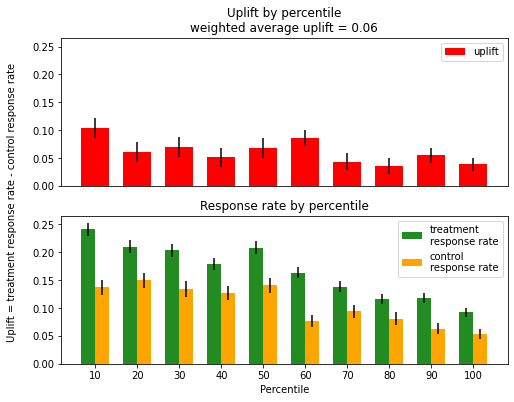

In [12]:
plot_uplift_by_percentile(y_test, uplift_sm, treat_test, 
                          strategy='overall', kind='bar');

Данный график позволяет оценить с какой целевой группой лучше контактировать. Т.е. где будет больше uplift, с теми и будем взаимодействовать. На верхнем графике показаны значения uplift. А на нижнем показаны отклики на целевой(зеленый столбец) и контрольной(желтый) группы.

Посмотрим на топ признаки

In [13]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,is_referral,19.810960
1,treatment,17.591168
2,used_bogo,13.098781
3,zip_code,11.591993
4,used_discount,10.171163
5,recency,10.145851
6,history,8.933728
7,channel,8.656356


In [14]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': cat_cols})

uplift_ct = ct.predict(X_test)

ct_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {ct_score_10:.4f}')
print(f'uplift@20%: {ct_score_20:.4f}')

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_10)
models_results['uplift@20%'].append(ct_score_20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


uplift@10%: 0.1091
uplift@20%: 0.0821


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


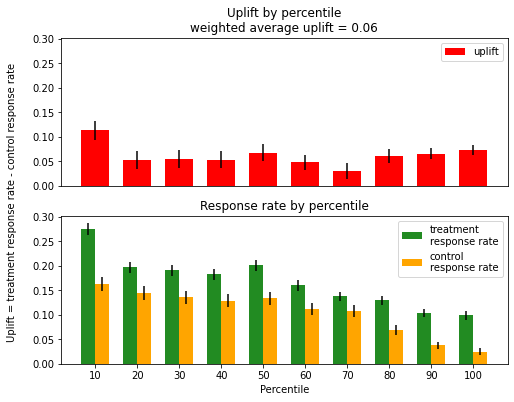

In [15]:
plot_uplift_by_percentile(y_test, uplift_ct, treat_test, 
                          strategy='overall', kind='bar');

Применяя модель с трансформацией таргета получаем график, который начинает приближаться к нормальному в части, что с увеличением процента, uplift должен уменьшаться для отсортированной выборки. Однако под конец видим рост. Так же заметим, что uplift для первых 10% увеличился, что говорит о том, что модель стала лучше находить лояльных пользователей.

uplift@10%: 0.0959
uplift@20%: 0.0907


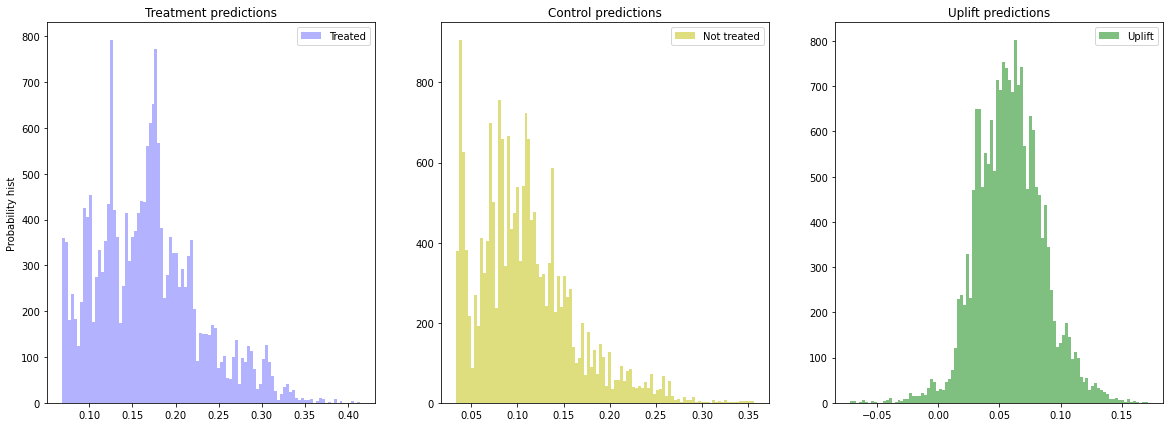

In [16]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(X_train, 
            y_train, 
            treat_train,
            estimator_trmnt_fit_params={'cat_features': cat_cols},
            estimator_ctrl_fit_params={'cat_features': cat_cols})

uplift_tm = tm.predict(X_test)

tm_score_10 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_20 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)
print(f'uplift@10%: {tm_score_10:.4f}')
print(f'uplift@20%: {tm_score_20:.4f}')

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_10)
models_results['uplift@20%'].append(tm_score_20)

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


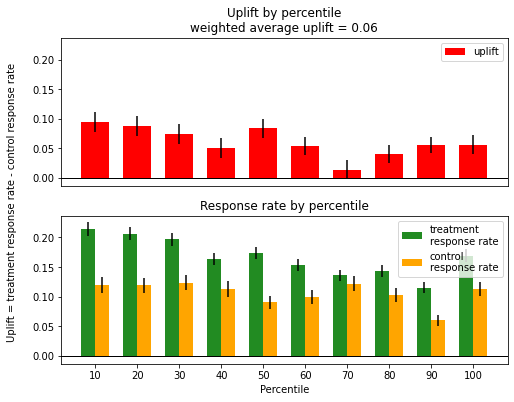

In [17]:
plot_uplift_by_percentile(y_test, uplift_tm, treat_test, 
                          strategy='overall', kind='bar');

In [18]:
pd.DataFrame(data=models_results)

,approach,uplift@10%,uplift@20%
0,SoloModel,0.101345,0.083675
1,ClassTransformation,0.109118,0.082092
2,TwoModels,0.095908,0.090746


Среди испробованных моделей лучший резльтат у ClassTransformation c 10%. Собственно и на графике с разбиением данные показывают результыта приближенный к нормалной модели.